# Emotion classifier in speech audio

*The problem*<br>
Classify the emotion of a speaking person from a short (3 second) audio utterance.

*Datasets* <br>
RAVDESS and TESS datasets, consisting of mostly short (up to 7 seconds) audio files.

*Constraints* <br>
Only the first 3 seconds of every audio file used to avoid cases with extreme padding. Shorter audio clips are padded to 3 seconds.

*Model results* (are bad, but could be improved a lot): <br>
M1: ResNet50 (L2 reg + Dropout): accuracy: 0.5469<br>
M2: ResNet50 (More reg + More dropout) : 0.4500<br>
M3: Custom 3-layer CNN: accuracy: 0.4625<br>

*Lessons learned* <br>
- Audio files can be analyzed as sequences (e.g. with RNNs) or as spectrograms (with CNNs). I only touched upon the tip of the iceberg - analyzed spetrograms with CNNs.
- Audio files are notoriously slow to read. Difficult to come up with a method that is fast and does not require to load imported audio files to memory.
- Preprocessing audio files that are diverse in length, sound, etc. is painful too. 
- Audio from different datasets can vary quite a bit. This suggests that running an audio AI product that can run on audio from diverse, noisy sources requires even more preprocessing/normalization. What I did here was simply use tanh on all audio files during preprocessing. This way we lose some important information though (e.g. differences between clips).
- Neither model converged to any stable results. Validation loss seems to start overfitting right away despite regularization and jumps up and down a lot. Could be remedied by adjusting model complexity, adding augmentation and reviewing differences in datasets.

## 0. Import libraries

In [0]:
import librosa
import numpy as np
from pathlib import *
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from typing import Tuple

# !pip uninstall tensorflow
# !pip install tensorflow-gpu==2.0.0
import tensorflow as tf
from tensorflow import keras

# !pip uninstall tqdm
# !pip install tqdm
from tqdm.auto import tqdm 

import IPython.display as ipd

## 0.1 Download datasets

3 datasets are downloaded (2 are used): Crema-D, RAVDESS and TESS. All of them contain labels that can be alligned to a single label map of 8 emotions.

In [0]:
# keys = eval(open('/content/kaggle.json', 'r').read())

# !pip uninstall -y kaggle
# !pip install --upgrade pip
# !pip install kaggle==1.5.6

# os.environ['KAGGLE_USERNAME'] = keys["username"]  
# os.environ['KAGGLE_KEY'] = keys["key"]
# !kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!wget https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip

--2020-02-19 09:07:11--  https://zenodo.org/record/1188976/files/Audio_Song_Actors_01-24.zip
Resolving zenodo.org (zenodo.org)... 188.184.95.95
Connecting to zenodo.org (zenodo.org)|188.184.95.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225505317 (215M) [application/octet-stream]
Saving to: ‘Audio_Song_Actors_01-24.zip’

Audio_Song_Actors_0 100%[===================>] 215.06M  34.7MB/s    in 5.0s    

2020-02-19 09:07:16 (42.8 MB/s) - ‘Audio_Song_Actors_01-24.zip’ saved [225505317/225505317]



In [0]:
!wget https://github.com/CheyneyComputerScience/CREMA-D/archive/master.zip

--2020-02-19 09:07:18--  https://github.com/CheyneyComputerScience/CREMA-D/archive/master.zip
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/CheyneyComputerScience/CREMA-D/zip/master [following]
--2020-02-19 09:07:18--  https://codeload.github.com/CheyneyComputerScience/CREMA-D/zip/master
Resolving codeload.github.com (codeload.github.com)... 192.30.253.121
Connecting to codeload.github.com (codeload.github.com)|192.30.253.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [         <=>        ]  22.31M  4.88MB/s    in 4.6s    

2020-02-19 09:07:23 (4.88 MB/s) - ‘master.zip’ saved [23391027]



#### Unzip data to Data Dir

In [0]:
DATA_DIR = Path("/content/drive/My\ Drive/audio_data")

In [0]:
# Unzip Ravdess
!unzip -d {DATA_DIR} Audio_Song_Actors_01-24.zip

In [0]:
!mkdir {DATA_DIR}/ravdess
!mv {DATA_DIR}/* {DATA_DIR}/ravdess

mv: cannot move '/content/drive/My Drive/audio_data/ravdess' to a subdirectory of itself, '/content/drive/My Drive/audio_data/ravdess/ravdess'


In [0]:
# Unzip Tess
!mkdir {DATA_DIR}/tess
!unzip -d {DATA_DIR}/tess toronto-emotional-speech-set-tess.zip

In [0]:
!rm -r {DATA_DIR}/tess/tess\ toronto\ emotional\ speech\ set\ data
!mv {DATA_DIR}/tess/TESS\ Toronto\ emotional\ speech\ set\ data/* {DATA_DIR}/tess
!rm -r {DATA_DIR}/tess/TESS\ Toronto\ emotional\ speech\ set\ data

In [0]:
# Unzip Crema-D
!unzip master.zip
!mkdir {DATA_DIR}/crema_d

In [0]:
!mv CREMA-D-master/AudioWAV/* {DATA_DIR}/crema_d

In [0]:
!ls {DATA_DIR}

crema_d  ravdess  tess


#### Let's check the contents

In [0]:
!ls {DATA_DIR}/ravdess

Actor_01  Actor_04  Actor_07  Actor_10	Actor_13  Actor_16  Actor_19  Actor_22
Actor_02  Actor_05  Actor_08  Actor_11	Actor_14  Actor_17  Actor_20  Actor_23
Actor_03  Actor_06  Actor_09  Actor_12	Actor_15  Actor_18  Actor_21  Actor_24


In [0]:
!ls {DATA_DIR}/tess

OAF_angry    OAF_neutral	    YAF_disgust  YAF_pleasant_surprised
OAF_disgust  OAF_Pleasant_surprise  YAF_fear	 YAF_sad
OAF_Fear     OAF_Sad		    YAF_happy
OAF_happy    YAF_angry		    YAF_neutral


In [0]:
!ls {DATA_DIR}/crema_d | head -5

1001_DFA_ANG_XX.wav
1001_DFA_DIS_XX.wav
1001_DFA_FEA_XX.wav
1001_DFA_HAP_XX.wav
1001_DFA_NEU_XX.wav


## 1. EDA + preprocessing

6/8 emotions across the three datasets are approximately equally distributed. Surprised and calm are highly under-represented. Audio files vary between 1 and 7 seconds.

In [0]:
# Get filenames
filenames = []

for currentpath, folders, files in os.walk("/content/drive/My Drive/audio_data"):
    for file in files:
        filenames.append(os.path.join(currentpath, file))

In [0]:
print(f"A total of {len(filenames)} audio file paths, e.g.: {filenames[0]}")

A total of 11257 audio file paths, e.g.: /content/drive/My Drive/audio_data/audio_raw.csv


In [0]:
# Create dataframe
data_raw = pd.DataFrame({"filename": filenames})
data_raw["dataset"] = data_raw["filename"].map(lambda x: x.split("/")[5])

In [0]:
data_raw.dataset.value_counts()

crema_d    7442
tess       2800
ravdess    1012
Name: dataset, dtype: int64

## 1.1 Label preprocessing

Labels are coded in different ways across the three datasets - some are in filenames, some are in directory names. Let's put it all to a DF.

#### Ravdess dataset

In [0]:
data_raw["label"] = ""

In [0]:
print("The labels should contain the third digit (after 2nd dash) of these filenames:")
[print(x[51:]) for x in data_raw.loc[data_raw["dataset"] == "ravdess", "filename"].head()]

The labels should contain the third digit (after 2nd dash) of these filenames:
/03-02-01-01-01-02-07.wav
/03-02-02-01-01-02-07.wav
/03-02-02-02-01-01-07.wav
/03-02-01-01-01-01-07.wav
/03-02-01-01-02-02-07.wav


[None, None, None, None, None]

In [0]:
print(data_raw.loc[data_raw["dataset"] == "ravdess", "filename"].str.extract(r'[0-9]+\-[0-9]+\-([0-9]+).*').head())
print("Looks good!")

    0
0  01
1  02
2  02
3  01
4  01
Looks good!


In [0]:
data_raw.loc[data_raw['dataset'] == 'ravdess', 'label'] = \
    data_raw.loc[data_raw['dataset'] == 'ravdess', 'filename'
                 ].str.extract(r'[0-9]+\-[0-9]+\-([0-9]+).*')[0]

In [0]:
# Apply label map
ravdess_label_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

data_raw["label"] = data_raw.label.map(ravdess_label_map)

In [0]:
data_raw.label.value_counts()

angry      184
calm       184
fearful    184
sad        184
happy      184
neutral     92
Name: label, dtype: int64

#### Tess dataset

In [0]:
# Check regex extractor
data_raw.loc[data_raw["dataset"] == "tess", "filename"].str.extract(".*tess/.*_(.*).wav")[0].value_counts()

angry      400
neutral    400
sad        400
happy      400
ps         400
fear       400
disgust    400
Name: 0, dtype: int64

In [0]:
data_raw.loc[data_raw["dataset"] == "tess", "label"] = \
    data_raw.loc[data_raw["dataset"] == "tess", "filename"
    ].str.extract(".*tess/.*_(.*).wav")[0]

In [0]:
tess_label_map = {
    "calm": "calm",
    "fearful": "fearful",
    "surprised": "surprised",
    "neutral": "neutral",
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "fear": "fearful",
    "disgust": "disgust",
    "ps": "surprised"
}

data_raw["label"] = data_raw.label.map(tess_label_map)

#### Crema-D dataset

In [0]:
data_raw.loc[data_raw["dataset"] == "crema_d", "filename"].str.extract(".*_([a-zA-Z]+)_[a-zA-Z]+.wav")[0].value_counts()

SAD    1271
HAP    1271
DIS    1271
FEA    1271
ANG    1271
NEU    1087
Name: 0, dtype: int64

In [0]:
data_raw.loc[data_raw["dataset"] == "crema_d", "label"] = \
    data_raw.loc[data_raw["dataset"] == "crema_d", "filename"
    ].str.extract(".*_([a-zA-Z]+)_[a-zA-Z]+.wav")[0]

In [0]:
crema_d_label_map = {
    "calm": "calm",
    "fearful": "fearful",
    "surprised": "surprised",
    "neutral": "neutral",
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "disgust": "disgust",
    "SAD": "sad",
    "ANG": "angry",
    "DIS": "disgust",
    "FEA": "fearful",
    "HAP": "happy",
    "NEU": "neutral"
}

data_raw["label"] = data_raw.label.map(crema_d_label_map)

#### Final label distribution

In [0]:
data_raw.label.value_counts()

angry        1855
fearful      1855
sad          1855
happy        1855
disgust      1671
neutral      1579
surprised     400
calm          184
Name: label, dtype: int64

#### Check audio files

In [0]:
# Check if no missing labels
assert data_raw.label.value_counts().sum() == len(data_raw)

In [0]:
audio_raw = data_raw.filename[:2000].map(lambda x: librosa.load(x, sr=22050)[0])

In [0]:
audio_raw[0]

array([ 1.3684871e-06, -1.5953108e-06,  1.8995546e-06, ...,
        1.0923847e-06, -8.8504845e-07,  0.0000000e+00], dtype=float32)

In [0]:
audio_raw.to_csv("data_raw.csv", index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [0]:
audio_raw = pd.DataFrame(audio_raw)
audio_raw.columns = ["data"]
audio_raw["label"] = data_raw.label[:2000]
audio_raw["audio_length"] = audio_raw.data.map(lambda x: len(x) / 22050)

#### Audio length distribution

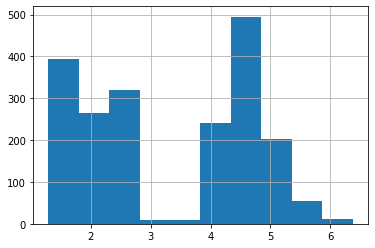

In [0]:
audio_raw.audio_length.hist()

#### Audio preview

In [10]:
ipd.Audio('YAF_bar_angry.wav')

In [11]:
ipd.Audio('OAF_bar_ps.wav')

#### Save pre-processed data

In [0]:
data_raw.to_csv('/content/drive/My Drive/audio_data/data_raw.csv')

## 2. Data generator

The audio files will be preprocessed in the following way:<br>
1. Each audio file will be read into an array and converted into a spectrogram (image).<br>
2. To limit the complexity, we will use the first 3 seconds of audio, and pad shorter audio files to 3s.<br>
3. A generator will loop over audio files and accumulate them to batches.
4. This generator will be fed into a tf Dataset that will convert it to a 3-channel image, shuffle and prefetch it.

In [0]:
# Read the data back, use 2/3 datasets
data_raw = pd.read_csv('/content/drive/My Drive/audio_data/data_raw.csv')
data_raw = data_raw.drop(data_raw.loc[data_raw["dataset"] == "crema_d", :].index).sample(frac=1).reset_index()

In [0]:
# Read audio file, convert to spectrogram
def make_spectrogram(filename: str, n_mels: int = 40):
    waveform, sr = librosa.load(filename, sr=22050, duration=3., res_type='kaiser_fast')
    spectrogram = librosa.feature.melspectrogram(waveform, sr=sr, n_mels=n_mels)
    return np.array(spectrogram)

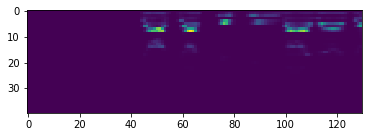

In [19]:
# Check spectrogram
import matplotlib.pyplot as plt
plt.imshow(make_spectrogram(data_raw.filename[0], n_mels=40))

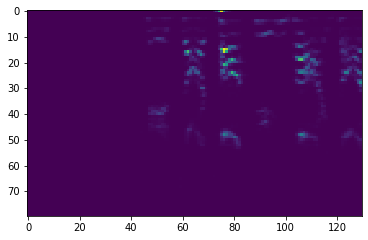

In [32]:
plt.imshow(make_spectrogram(data_raw.filename[1395], n_mels=80))

In [0]:
# Read all audio files into a DF
tqdm.pandas()

data_raw["audio_spectro"] = data_raw.filename.progress_map(lambda x: make_spectrogram(x, 40))

In [0]:
# data_raw.to_csv("/content/drive/My Drive/audio_data/data_spectr_3s_40.csv")
# np.save("/content/drive/My Drive/audio_data/audio_spectro_3s_40.npy", data_raw.audio_spectro.to_numpy())

In [0]:
data_raw = pd.read_csv("/content/drive/My Drive/audio_data/data_spectr_3s_40.csv")
data_raw["audio_spectro"] = np.load("/content/drive/My Drive/audio_data/audio_spectro_3s_40.npy", allow_pickle=True)

In [0]:
# Scale data
def scale_data(df: pd.DataFrame, data_col: str, 
               mean: float = None, std: float = None):
  df_copy = df.copy()
  if mean:
    master_mean = mean
  else:
    master_mean = df_copy.audio_spectro.apply(np.mean).mean()
  if std:
    master_std = std
  else:
    master_std = df_copy.audio_spectro.apply(np.std).mean()
  df_copy[data_col] = (df_copy[data_col] - master_mean) / master_std / 100
  return df_copy

In [0]:
# Pad sequences to selected length
def pad_to(sequence: np.ndarray, pad_length: int):
  if sequence.shape[1] < pad_length:
    return np.pad(sequence, ((0,0), (0, pad_length - sequence.shape[1])), mode='mean')
  else:
    return sequence

In [0]:
def preprocess_audio(dataframe: pd.DataFrame, filename_col: str = "filename", 
                     label_col: str = "label", seconds: int = 1, bs=32,
                     master_mean: np.float32 = None, master_std: np.float32 = None,
                     label_map: dict = None):
  
    # If train data, scale with own mean/std
    # If val: scale with train mean/std
    if master_mean and master_std:
      dataframe = scale_data(dataframe, filename_col, master_mean, master_std)
    else:
      dataframe = scale_data(dataframe, filename_col)

    xs_cumulative = None
    ys_cumulative = None
    while True:
      for index_row in dataframe.index:
        spectrogram = dataframe.loc[index_row, filename_col] 
        spectrogram_split = pad_to(spectrogram, seconds * 44)
        xs = np.expand_dims(spectrogram_split, 0)
        y = dataframe[label_col].map(label_map).loc[index_row]
        ys = np.repeat(y, xs.shape[0])
        if xs_cumulative is None:
          xs_cumulative = xs
          ys_cumulative = ys
        elif xs_cumulative.shape[0] <= bs:
          try:
            xs_cumulative = np.append(xs, xs_cumulative, axis=0)
            ys_cumulative = np.append(ys, ys_cumulative, axis=0)
          except:
            pass
        else:
          if len(xs_cumulative.shape) == 3:
            yield tf.constant(np.tanh(xs_cumulative[:bs,...]), dtype=tf.float32), tf.constant(ys_cumulative[:bs], dtype=tf.int8)
            xs_cumulative = None
            ys_cumulative = None
          else: 
            xs_cumulative = None
            ys_cumulative = None
          


In [0]:
# Get label map to pass to generator
label_map = {
    "angry": 0,
    "fearful": 1,
    "sad": 2,
    "happy": 3,
    "disgust": 4,
    "neutral": 5,
    "surprised": 6,
    "calm": 7
}

#### Split data + make generators

In [0]:
# Split the data
train_data, val_data = train_test_split(data_raw, test_size=0.2)
val_data, test_data = train_test_split(val_data, test_size=0.5)

# Make train data generator
train_datagen = preprocess_audio(train_data, "audio_spectro", "label", 
                                 seconds=3, bs=64, label_map=label_map)

# Get train mean and std for validation scaling
train_mean = train_data.audio_spectro.apply(np.mean).mean()
train_std = train_data.audio_spectro.apply(np.std).mean()

# Validation generator
val_datagen = preprocess_audio(val_data, "audio_spectro", "label", seconds=3, bs=64,
                               master_mean=train_mean, master_std=train_std, 
                               label_map=label_map)

test_datagen = preprocess_audio(test_data, "audio_spectro", "label", seconds=3, bs=64,
                               master_mean=train_mean, master_std=train_std, 
                               label_map=label_map)

In [0]:
print(f"Total N: {len(train_data) + len(val_data)}")
print("Train dataset shapes:")
print(f"Train X: {next(train_datagen)[0].shape}, train Y: {next(train_datagen)[1].shape}")
print("Val dataset shapes:")
print(f"Val X: {next(val_datagen)[0].shape}, val Y: {next(val_datagen)[1].shape}\n")
print("Batch means and stds:")
print(f"Train mean: {np.mean(next(train_datagen)[0])}, train std: {np.std(next(train_datagen)[1])}")
print(f"Val mean: {np.mean(next(val_datagen)[0])}, val std: {np.std(next(val_datagen)[1])}")

Total N: 3430
Train dataset shapes:
Train X: (64, 40, 132), train Y: (64,)
Val dataset shapes:
Val X: (64, 40, 132), val Y: (64,)

Batch means and stds:
Train mean: -5.4133797675604e-05, train std: 2.001708254841349
Val mean: 0.0003017912385985255, val std: 2.0365315950163896


#### Tensorflow generator

In [0]:
INPUT_SHAPE = [64,40,132,3]
autotune = tf.data.experimental.AUTOTUNE

def set_shapes(inputs, label, input_shape):
    inputs.set_shape(input_shape)
    label.set_shape(input_shape[0])
    return inputs, label

def data_tf_generator(generator, shuffle=False, input_shape=None):
  ds = tf.data.Dataset.from_generator(lambda: generator, output_types=(tf.float32, tf.int8))
  ds = ds.map(lambda x,y: (tf.stack([x,x,x], axis=-1), y), num_parallel_calls=autotune)
  ds = ds.map(lambda x,y: set_shapes(x,y,input_shape), num_parallel_calls=autotune)
  if shuffle:
    ds = ds.shuffle(64)
  ds = ds.repeat().prefetch(autotune)
  return ds

In [0]:
def get_train_data():
  return data_tf_generator(train_datagen, input_shape=INPUT_SHAPE, shuffle=True)

def get_val_data():
  return data_tf_generator(val_datagen, input_shape=INPUT_SHAPE)

def get_test_data():
  return data_tf_generator(test_datagen, input_shape=INPUT_SHAPE)

In [0]:
for x,y in get_train_data().take(1):
  print(x.shape, y.shape)

for x,y in get_val_data().take(1):
  print(x.shape, y.shape)

(64, 40, 132, 3) (64,)
(64, 40, 132, 3) (64,)


## 3. Model definition

We will use vanilla ResNet50 with no pre-trained weights. <br>
- Architecture choice was driven by minimal input size - although XCeption would have been nice, it requires at least [71,71] images, which is slow to obtain when making spectrograms from audio files.
- No pre-trained weights were selected, since imagenet and other major datasets contain categories that are not useful for spectrograms. No useful information in those weights.

In [0]:
# Define model creator
def model_creator(base_model: keras.models.Model,
                  input_shape: Tuple,
                  dropout: float,
                  output_layer: keras.layers.Layer) -> keras.Model:
                  
        base_model = base_model(
            include_top=False, weights=None, input_shape=(input_shape))
        concat_layer = keras.layers.concatenate(
            [
                keras.layers.GlobalAvgPool2D()(base_model.output),
                keras.layers.GlobalMaxPool2D()(base_model.output),
            ]
        )

        dropout = keras.layers.Dropout(dropout)(concat_layer)

        batchnorm = keras.layers.BatchNormalization()(dropout)
        output = output_layer(batchnorm)
        return keras.Model(inputs=base_model.input, outputs=output)

In [0]:
# Define model 1
model_1 = model_creator(
    keras.applications.ResNet50, 
    input_shape=(40,132,3),
    dropout=0.2, 
    output_layer=keras.layers.Dense(8, activation="softmax")
    )

In [0]:
# Define callbacks and compile
callbacks = [
            keras.callbacks.ReduceLROnPlateau(factor=0.33, patience=4),
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            ]

model_1.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, 
                metrics=["accuracy"], lr=1e-4)

In [0]:
model_1.fit(get_train_data(), validation_data=get_val_data(), 
            epochs=30, steps_per_epoch=len(train_data) // 64, 
            validation_steps=len(val_data) // 64)

Train for 47 steps, validate for 5 steps
Epoch 1/30
47/47 [==============================] - 28s 587ms/step - loss: 1.4915 - accuracy: 0.5153 - val_loss: 29.7888 - val_accuracy: 0.1250
Epoch 2/30
47/47 [==============================] - 10s 205ms/step - loss: 0.6272 - accuracy: 0.7872 - val_loss: 4.9652 - val_accuracy: 0.1500
Epoch 3/30
47/47 [==============================] - 10s 204ms/step - loss: 0.4592 - accuracy: 0.8501 - val_loss: 4.2737 - val_accuracy: 0.1437
Epoch 4/30
47/47 [==============================] - 9s 189ms/step - loss: 0.3590 - accuracy: 0.8760 - val_loss: 3.7993 - val_accuracy: 0.1031
Epoch 5/30
47/47 [==============================] - 9s 186ms/step - loss: 0.3614 - accuracy: 0.8860 - val_loss: 2031.0920 - val_accuracy: 0.1312
Epoch 6/30
47/47 [==============================] - 9s 194ms/step - loss: 0.3230 - accuracy: 0.9013 - val_loss: 5.9528 - val_accuracy: 0.1594
Epoch 7/30
47/47 [==============================] - 9s 190ms/step - loss: 0.2937 - accuracy: 0.9189 

#### Comment
The validation loss looks somewhat all over the place after a certain period. Let's try to add some regularization in the output layer and increase dropout.

In [0]:
# Define model creator
def model_creator(base_model: keras.models.Model,
                  input_shape: Tuple,
                  dropout: float,
                  n_dense: int,
                  l2: float,
                  output_layer: keras.layers.Layer,) -> keras.Model:
                  
        base_model = base_model(
            include_top=False, weights=None, input_shape=(input_shape))
        pool_layer = keras.layers.GlobalAvgPool2D()(base_model.output)
        neck = keras.layers.Dense(n_dense, 
                                  activation="relu",
                                  kernel_initializer="he_uniform",
                                  kernel_regularizer=keras.regularizers.l2(l=l2))(pool_layer) 
        dropout = keras.layers.Dropout(dropout)(neck)
        batchnorm = keras.layers.BatchNormalization()(dropout)
        output = output_layer(batchnorm)
        return keras.Model(inputs=base_model.input, outputs=output)


# Define model 1
model_2 = model_creator(
    keras.applications.ResNet50, 
    input_shape=(40,132,3),
    dropout=0.35, 
    n_dense=256,
    l2=1e-5,
    output_layer=keras.layers.Dense(8, activation="softmax")
    )

In [0]:
# Compile
model_2.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, 
                metrics=["accuracy"], lr=1e-4)

In [0]:
model_2.fit(get_train_data(), validation_data=get_val_data(), 
            epochs=30, steps_per_epoch=len(train_data) // 64, 
            validation_steps=len(val_data) // 64)

Train for 47 steps, validate for 5 steps
Epoch 1/30
47/47 [==============================] - 28s 603ms/step - loss: 1.9616 - accuracy: 0.2520 - val_loss: 2.2020 - val_accuracy: 0.1312
Epoch 2/30
47/47 [==============================] - 10s 210ms/step - loss: 1.5079 - accuracy: 0.4006 - val_loss: 2.5367 - val_accuracy: 0.1437
Epoch 3/30
47/47 [==============================] - 10s 206ms/step - loss: 1.1029 - accuracy: 0.5851 - val_loss: 3.2180 - val_accuracy: 0.1500
Epoch 4/30
47/47 [==============================] - 9s 194ms/step - loss: 0.7425 - accuracy: 0.7394 - val_loss: 4.2493 - val_accuracy: 0.1625
Epoch 5/30
47/47 [==============================] - 8s 176ms/step - loss: 0.5853 - accuracy: 0.7985 - val_loss: 2.7626 - val_accuracy: 0.1437
Epoch 6/30
47/47 [==============================] - 10s 205ms/step - loss: 0.5358 - accuracy: 0.8055 - val_loss: 8.4227 - val_accuracy: 0.1344
Epoch 7/30
47/47 [==============================] - 9s 195ms/step - loss: 0.4404 - accuracy: 0.8434 - v

In [0]:
model_3 = model_creator(
    keras.applications.ResNet50, 
    input_shape=(40,132,3),
    dropout=0.45, 
    n_dense=256,
    l2=1e-4,
    output_layer=keras.layers.Dense(8, activation="softmax")
    )

In [0]:
# Compile
model_3.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, 
                metrics=["accuracy"], lr=1e-4)

In [0]:
model_3.fit(get_train_data(), validation_data=get_val_data(), 
            epochs=30, steps_per_epoch=len(train_data) // 64, 
            validation_steps=len(val_data) // 64)

Train for 47 steps, validate for 5 steps
Epoch 1/30
47/47 [==============================] - 27s 571ms/step - loss: 2.0664 - accuracy: 0.2330 - val_loss: 2.2917 - val_accuracy: 0.1250
Epoch 2/30
47/47 [==============================] - 10s 206ms/step - loss: 1.5226 - accuracy: 0.4146 - val_loss: 2.8603 - val_accuracy: 0.1375
Epoch 3/30
47/47 [==============================] - 10s 207ms/step - loss: 1.1075 - accuracy: 0.6074 - val_loss: 3.6443 - val_accuracy: 0.1406
Epoch 4/30
47/47 [==============================] - 9s 186ms/step - loss: 0.8291 - accuracy: 0.7164 - val_loss: 4.3919 - val_accuracy: 0.1344
Epoch 5/30
47/47 [==============================] - 9s 193ms/step - loss: 0.6323 - accuracy: 0.7889 - val_loss: 3.0333 - val_accuracy: 0.1500
Epoch 6/30
47/47 [==============================] - 9s 185ms/step - loss: 0.5553 - accuracy: 0.8271 - val_loss: 2.4864 - val_accuracy: 0.1344
Epoch 7/30
47/47 [==============================] - 9s 195ms/step - loss: 0.4428 - accuracy: 0.8627 - va

#### Comment
This still seems quite unstable. Let's try a more simple model to check if the overfitting and variance of val loss decreases.

In [0]:
# Simple convnet model (Sequential API for fun.)
def make_model_no_transfer(
  input_shape,
  n_conv_layers: int,
  conv_depths,
  dropout,
  l1,
  l2,
):
  
  model = keras.models.Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(keras.layers.Conv2D(conv_depths[0], (7,7), strides=(1,1)))
  model.add(keras.layers.Activation('relu'))
  model.add(keras.layers.BatchNormalization())
  
  if n_conv_layers > 1:
    for i in range(n_conv_layers-1):
      model.add(keras.layers.Conv2D(conv_depths[i+1], (7,7), strides=(1,1)))
      model.add(keras.layers.BatchNormalization())
      model.add(keras.layers.Activation('relu'))

  model.add(keras.layers.GlobalAveragePooling2D())
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.Dropout(dropout))
  model.add(keras.layers.Dense(
    8,
    activation=keras.activations.softmax))
    
  return model

In [0]:
model_4 = make_model_no_transfer(INPUT_SHAPE[1:], 3, [256, 256, 128], 0.4, 1e-4, 1e-3)

In [0]:
# Compile
model_4.compile(optimizer='adam', loss=keras.losses.sparse_categorical_crossentropy, 
                metrics=["accuracy"], lr=1e-4)

In [0]:
model_4.fit(get_train_data(), validation_data=get_val_data(), 
            epochs=30, steps_per_epoch=len(train_data) // 64, 
            validation_steps=len(val_data) // 64)

Train for 47 steps, validate for 5 steps
Epoch 1/30
47/47 [==============================] - 26s 558ms/step - loss: 1.9412 - accuracy: 0.2859 - val_loss: 2.0701 - val_accuracy: 0.1406
Epoch 2/30
47/47 [==============================] - 18s 379ms/step - loss: 1.6227 - accuracy: 0.4126 - val_loss: 2.1051 - val_accuracy: 0.1656
Epoch 3/30
47/47 [==============================] - 18s 379ms/step - loss: 1.3570 - accuracy: 0.5253 - val_loss: 2.1823 - val_accuracy: 0.1500
Epoch 4/30
47/47 [==============================] - 18s 378ms/step - loss: 1.1352 - accuracy: 0.6054 - val_loss: 2.2480 - val_accuracy: 0.1844
Epoch 5/30
47/47 [==============================] - 18s 379ms/step - loss: 1.0260 - accuracy: 0.6400 - val_loss: 2.3003 - val_accuracy: 0.1906
Epoch 6/30
47/47 [==============================] - 18s 378ms/step - loss: 0.8904 - accuracy: 0.6922 - val_loss: 2.6530 - val_accuracy: 0.1719
Epoch 7/30
47/47 [==============================] - 18s 377ms/step - loss: 0.8238 - accuracy: 0.7124 

KeyboardInterrupt: ignored

## 4. Evaluate models on test data

In [0]:
print("Test accuracy:")
print(f"Model 2: {model_2.evaluate(get_test_data(), steps = len(val_data) // 64)}")
print(f"Model 3: {model_3.evaluate(get_test_data(), steps = len(val_data) // 64)}")
print(f"Model 4: {model_4.evaluate(get_test_data(), steps = len(val_data) // 64)}")

Test accuracy:
5/5 [==============================] - 1s 136ms/step - loss: 2.4208 - accuracy: 0.5469
Model 2: [2.420772409439087, 0.546875]
5/5 [==============================] - 2s 364ms/step - loss: 4.2371 - accuracy: 0.4500
Model 3: [4.237071323394775, 0.45]
5/5 [==============================] - 1s 138ms/step - loss: 2.6007 - accuracy: 0.4625
Model 4: [2.6007179260253905, 0.4625]
